In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

To be able to process locally, we will use 1% of data. After that, we still have a large number of 241,179 records.

In [2]:
df = pd.read_csv('data/train.csv.gz', sep=',').dropna()
df = df.sample(frac=0.01, random_state=99)

In [3]:
df.shape

(241179, 24)

In [4]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
32352134,2014-05-22 11:40:07,2,3,66,174,24103,2323.5232,802499,0,1,...,0,1,1442,3,0,1,4,125,177,44
29796021,2013-06-29 12:24:37,2,3,66,311,25538,2288.6121,85229,0,0,...,1,1,8272,1,0,1,2,50,659,59
15185156,2014-10-30 13:58:32,2,3,66,294,40046,587.6970,755217,0,1,...,0,1,11321,1,0,1,2,50,642,22
3301948,2014-08-22 20:14:34,2,3,66,332,55121,2234.4394,160733,0,1,...,0,1,1152,1,1,1,4,47,1502,65
25429119,2014-03-25 18:47:43,2,3,66,314,47869,839.0087,1078493,0,0,...,0,1,8284,1,0,4,2,50,685,6


Text(0, 0.5, 'Frequency')

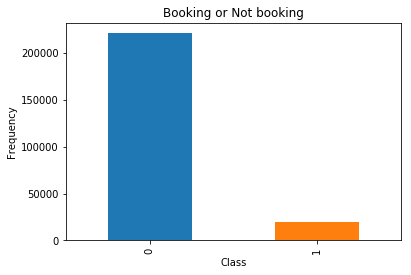

In [5]:
count_classes = pd.value_counts(df['is_booking'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Booking or Not booking")
plt.xlabel("Class")
plt.ylabel("Frequency")

It is obvious that our data is very imbalanced. We will have to deal with it.

Data quality check

In [6]:
df.isnull().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
dtype: int64

In [7]:
df.dtypes

date_time                     object
site_name                      int64
posa_continent                 int64
user_location_country          int64
user_location_region           int64
user_location_city             int64
orig_destination_distance    float64
user_id                        int64
is_mobile                      int64
is_package                     int64
channel                        int64
srch_ci                       object
srch_co                       object
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
srch_destination_id            int64
srch_destination_type_id       int64
is_booking                     int64
cnt                            int64
hotel_continent                int64
hotel_country                  int64
hotel_market                   int64
hotel_cluster                  int64
dtype: object

### Feature engineering
The process includes create new columns such as year, month, plan time and hotel nights. And remove the columns we do not need anymore afterwards.

In [8]:
df["date_time"] = pd.to_datetime(df["date_time"]) 
df["year"] = df["date_time"].dt.year  
df["month"] = df["date_time"].dt.month

df['srch_ci']=pd.to_datetime(df['srch_ci'],infer_datetime_format = True,errors='coerce')
df['srch_co']=pd.to_datetime(df['srch_co'],infer_datetime_format = True,errors='coerce')

df['plan_time'] = ((df['srch_ci']-df['date_time'])/np.timedelta64(1,'D')).astype(float)
df['hotel_nights']=((df['srch_co']-df['srch_ci'])/np.timedelta64(1,'D')).astype(float)

cols_to_drop = ['date_time', 'srch_ci', 'srch_co', 'user_id']
df.drop(cols_to_drop, axis=1, inplace=True)

In [9]:
df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,plan_time,hotel_nights
32352134,2,3,66,174,24103,2323.5232,0,1,9,2,...,0,1,4,125,177,44,2014,5,62.513808,0.0
29796021,2,3,66,311,25538,2288.6121,0,0,9,3,...,0,1,2,50,659,59,2013,6,5.482905,4.0
15185156,2,3,66,294,40046,587.6970,0,1,9,2,...,0,1,2,50,642,22,2014,10,49.417685,3.0
3301948,2,3,66,332,55121,2234.4394,0,1,9,2,...,1,1,4,47,1502,65,2014,8,153.156551,7.0
25429119,2,3,66,314,47869,839.0087,0,0,9,4,...,0,4,2,50,685,6,2014,3,22.216863,3.0


Plot a correlation matrix using a heatmap to explore the correlation between features. Nothing really exciting here. 

Text(0.5, 1.0, 'Correlation between different fearures')

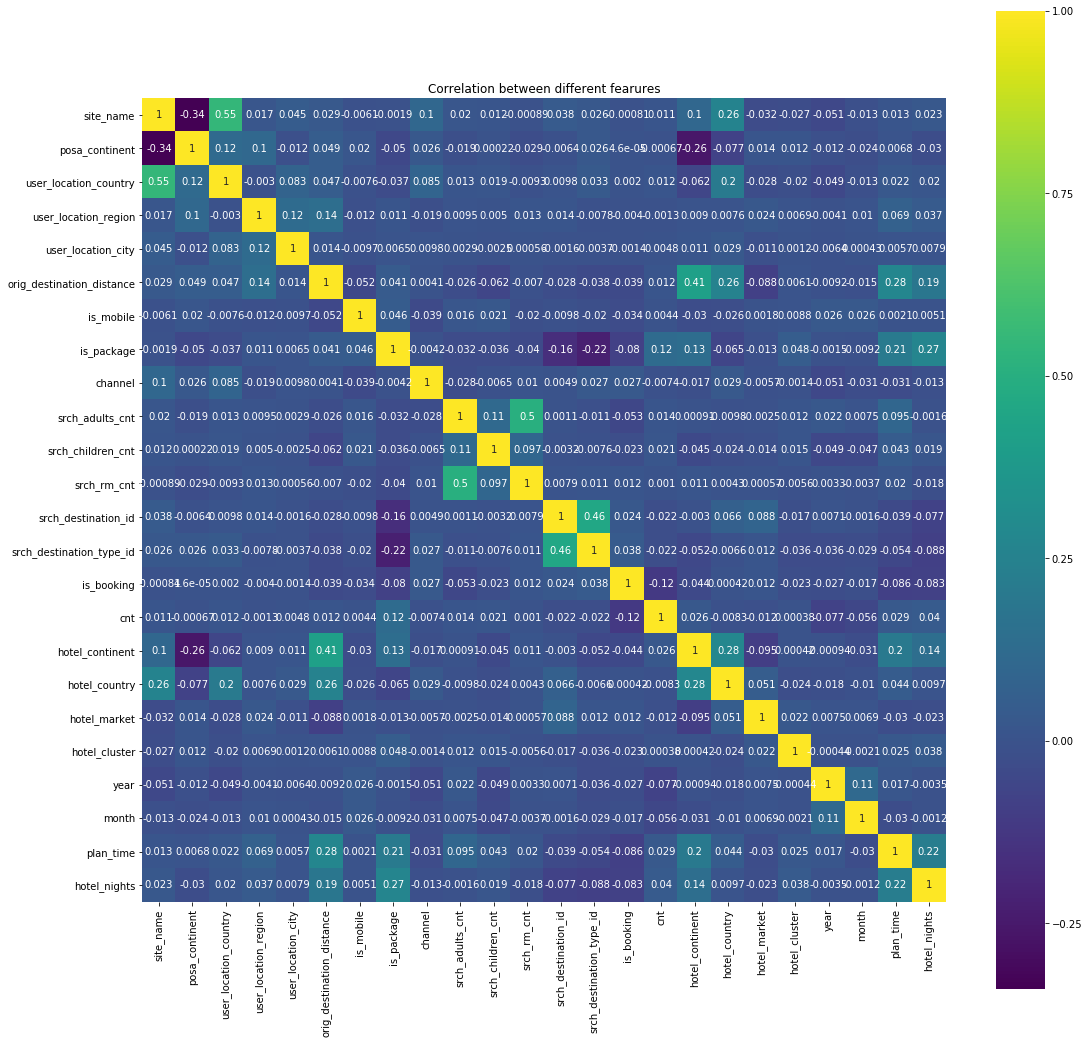

In [10]:
correlation = df.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between different fearures')

Look at the correlation of each column compared to the other one. We do not see any two variables are very closely correlated.

### Dealing with imbalanced data

In [11]:
booking_indices = df[df.is_booking == 1].index
random_indices = np.random.choice(booking_indices, len(df.loc[df.is_booking == 1]), replace=False)
booking_sample = df.loc[random_indices]

not_booking = df[df.is_booking == 0].index
random_indices = np.random.choice(not_booking, sum(df['is_booking']), replace=False)
not_booking_sample = df.loc[random_indices]

df_new = pd.concat([not_booking_sample, booking_sample], axis=0)

print("Percentage of not booking clicks: ", len(df_new[df_new.is_booking == 0])/len(df_new))
print("Percentage of booking clicks: ", len(df_new[df_new.is_booking == 1])/len(df_new))
print("Total number of records in resampled data: ", len(df_new))

Percentage of not booking clicks:  0.5
Percentage of booking clicks:  0.5
Total number of records in resampled data:  40064


Shuffle the resampled dataframe.

In [12]:
df_new = df_new.sample(frac=1).reset_index(drop=True)

In [13]:
df_new.shape

(40064, 24)

Assign features and label from the new dataframe.

In [14]:
X = df_new.loc[:, df_new.columns != 'is_booking']
y = df_new.loc[:, df_new.columns == 'is_booking']

In [15]:
X.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,plan_time,hotel_nights
0,18,2,66,174,13277,263.3098,0,0,9,5,...,1,1,2,50,355,16,2014,7,5.790625,1.0
1,2,3,66,348,48862,11.3757,0,1,9,1,...,1,1,2,50,674,28,2014,10,24.601667,0.0
2,2,3,66,311,48943,2077.7933,0,1,2,3,...,1,1,4,96,201,0,2014,9,176.592326,9.0
3,2,3,66,442,46296,1526.0954,0,0,9,2,...,3,1,2,50,696,90,2014,12,9.236597,4.0
4,2,3,66,348,48862,2556.7614,0,0,9,2,...,4,1,2,50,352,94,2014,6,43.430231,1.0


## PCA 
Principal component analysis, or PCA, is a statistical technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset.

Standardize the dataset

In [16]:
scaler = StandardScaler()
X=scaler.fit_transform(X)
X

D:\programs\Continuum\miniconda3\envs\py35\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\programs\Continuum\miniconda3\envs\py35\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 1.28004615e+00, -1.67747337e+00, -4.04753313e-01, ...,
        -5.10614031e-03, -6.45362234e-01, -5.96537678e-01],
       [-4.67356946e-01,  1.89731172e-01, -4.04753313e-01, ...,
         9.09524585e-01, -3.28166994e-01, -9.20214993e-01],
       [-4.67356946e-01,  1.89731172e-01, -4.04753313e-01, ...,
         6.04647677e-01,  2.23472743e+00,  1.99288084e+00],
       ...,
       [-4.67356946e-01,  1.89731172e-01, -4.04753313e-01, ...,
         2.99770768e-01,  7.49117913e-01,  5.08169506e-02],
       [-4.67356946e-01,  1.89731172e-01, -4.04753313e-01, ...,
        -3.09983049e-01,  3.24294237e+00,  6.52436324e+00],
       [-4.67356946e-01,  1.89731172e-01, -4.04753313e-01, ...,
         1.21440149e+00, -6.89543107e-01,  5.08169506e-02]])

Apply PCA. And we have 23 features in our data.

In [17]:
pca = PCA(n_components=23)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=23, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Calculate Eigenvalues

In [18]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

array([  9.3,  17.4,  24.3,  30.7,  36.3,  41.4,  46.3,  50.9,  55.4,
        59.8,  64.1,  68.2,  72.3,  76.2,  80.1,  83.7,  86.9,  89.9,
        92.4,  94.7,  96.8,  98.8, 100.1])

In the above array we see that the first feature explains 9.3% of the variance within our data set while the first two explain 17.3% and so on. If we employ all features we capture 99.9% of the variance within the dataset, thus we gain some by implementing an additional feature. No any single feature outstanding.

Step 4: Sort & Select

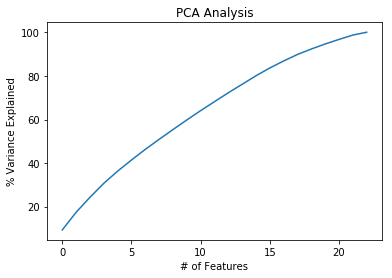

In [19]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')

plt.plot(var)

Based on the plot above it's clear we should keep all 23 features.

### Train, predict and performance evaluation

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape

(28044, 23)

In [21]:
pca = PCA()  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)

classifier = RandomForestClassifier(max_depth=2, random_state=0)  
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy', accuracy_score(y_test, y_pred))

D:\programs\Continuum\miniconda3\envs\py35\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\programs\Continuum\miniconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[[2789 3304]
 [1298 4629]]
Accuracy 0.6171381031613977


### Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
pca = PCA(n_components=23)
logReg = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', logReg)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy', accuracy_score(y_test, y_pred))

D:\programs\Continuum\miniconda3\envs\py35\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\programs\Continuum\miniconda3\envs\py35\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[3341 2752]
 [1074 4853]]
Accuracy 0.6816971713810316
